# Sinton Lifetime Analyser

This code opens a series of Sinton Lifetime Excel files, saves them into a panda dataframe, and displays a dash plot where the different files can be explored. 

You can then choose which of the files to analyse and plot separately.

First we start by importing some useful libraries.

text goes here.

In [11]:
import numpy as np
import matplotlib
import pandas as pd
import os
import warnings
from tkinter.filedialog import askdirectory
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# the library below is not standard, and needs to be added to the same folder.
import lifetime_functions_5 as tau_func
# additionally make sure that the 'SiliconData.mat' file also exists in the same folder.

 ### Now let's check all .xlsm files in a folder, and get a list of the files we will analyse. It gives the chance of adding or deleting files

In [12]:
# since the macro files from Sinton have some warnings, best to ignore them
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

# Create a dictionary to hold the dataframes
excel_files = {}

# Loop through all files in a directory selected by the user

#folder_path = os.getcwd() #start on the current directory, and find a new one selected by the user.

#folder_path = askdirectory(title='Select Folder',initialdir=folder_path) # shows dialog box and return the path

#if you want to deccide the folde path by text, use the line below
folder_path = 'C:\\Users\\corp1959\\OneDrive - Nexus365\\PYTHON\\lifetime_analyser\\Ana-lifetime'

print(folder_path)

for file in os.listdir(folder_path):
    # Check if the file is an Excel file
    if file.endswith('.xlsm'):
        # Create a dataframe from the Excel file
        file_path = os.path.join(folder_path, file)
        excel_files[file] = pd.read_excel(file_path)
print("Loaded Excel files:")
for file_name in excel_files:
    print(file_name)

C:\Users\corp1959\OneDrive - Nexus365\PYTHON\lifetime_analyser\Ana-lifetime
Loaded Excel files:
WS-12-1030E-1122HPs4.xlsm
WS-14-1030E-1122HPs4.xlsm


### Plot all of the lifetimes into a single plot that allows exploring the data.
If you get errors here it is likely some of the Excel Sinton files are corrupted or are using an older version of the software.

In [13]:
df_lib = {}# library of all the data_frames lodaded

# Create a Plotly figure with subplots
fig = make_subplots()
fig.update_xaxes(type='log',exponentformat = 'power'); fig.update_yaxes(type='log')
fig.update_xaxes(minor=dict(ticks="inside", ticklen=6, showgrid=True))
fig.update_xaxes(title_text="Delta N [cm^-3]"); fig.update_yaxes(title_text="Tau Effective (s)")

for file_name in excel_files:
    print("reading: ",file_name)
    file_path = os.path.join(folder_path, file_name)
    df1=pd.read_excel(file_path ,sheet_name='RawData')
    df3=pd.read_excel(file_path, sheet_name='User',nrows=1,header=4)

    #create a new dataframe that has all information of a single sample in it.
    trunc_ix=3; #remove the first and last 3 values of the lifetime plot.
    df = pd.DataFrame({df3.iloc[0,0]:#sample name
        [df3.iloc[0,1],#thickness in cm
        df3.iloc[0,2],#resisitivity in ohm.cm
        df3.iloc[0,3],#Si type
        df1['Minority Carrier Density'].iloc[trunc_ix:-trunc_ix],#iloc[4]: Delta_n
        df1['Tau (sec)'].iloc[trunc_ix:-trunc_ix]]})#iloc[5]: Teff
    
    df_lib[file_name]=df
    sample_name=df.columns[0]
    delta_n=df.iloc[3,0]
    tau_eff=df.iloc[4,0]
    fig.add_trace(go.Scatter(x=delta_n, y=tau_eff, mode='markers', name=file_name))

fig.update_layout(
    margin=dict(l=150, r=350, t=20, b=20),
    paper_bgcolor="white",
)
fig.show()

reading:  WS-12-1030E-1122HPs4.xlsm
reading:  WS-14-1030E-1122HPs4.xlsm


## Decide which excel file you would like to analyse to get the Surface Recombination parameters
To make sure it is all clear, here are all the main equations that define how these parameters are analysed.
### See more on
- RS Bonilla, et al (2017), Phys. Status Solidi A, 214: 1700293
- A. Kimmerle, J. Greulich, and A. Wolf, Sol. Energy Mater. Sol. Cells 142, 116–122 (2015).
- H. M€ackel and K. Varner, Prog. Photovolt. Res. Appl. 21, 850–866 (2013).
- B. Hammann et al., IEEE Journal of Photovoltaics, vol. 13, no. 4, pp. 535-546, July 2023.)



Starting from the effective lifetime measured in a Sinton tester $ \frac{1}{\tau_{eff}}=\frac{1}{\tau_{bulk_int}}+\frac{1}{\tau_{SRH}}+\frac{1}{\tau_{surf}} $.

Effective recombinaiton velocity is: $S_{eff}=\sqrt{D(\frac{1}{\tau_{surf}})}*\tan(W/2\sqrt{(\frac{1}{D\tau_{surf}})})$.  Which is often approximated to $S_{eff}=W/2(\frac{1}{\tau_{surf}})$

Then, J0 can be estimate from the average of the flat region of a plot of: $\frac{\partial}{\partial \Delta n}(n_i^2(S_{eff}))$ which requires the algorithm implemented for getting $J_{0S-avg}$, since we need to calculate an SRH recombination that makes  $J_{0s-avg}=\frac{qn_i^2S_{eff}}{N_{dop}+\Delta n} $ a true equation. Here $J_0$ would be a single value parameter, but it is of course possible to simply calculate S and then obtain a J0 as a function of minority carriers. 



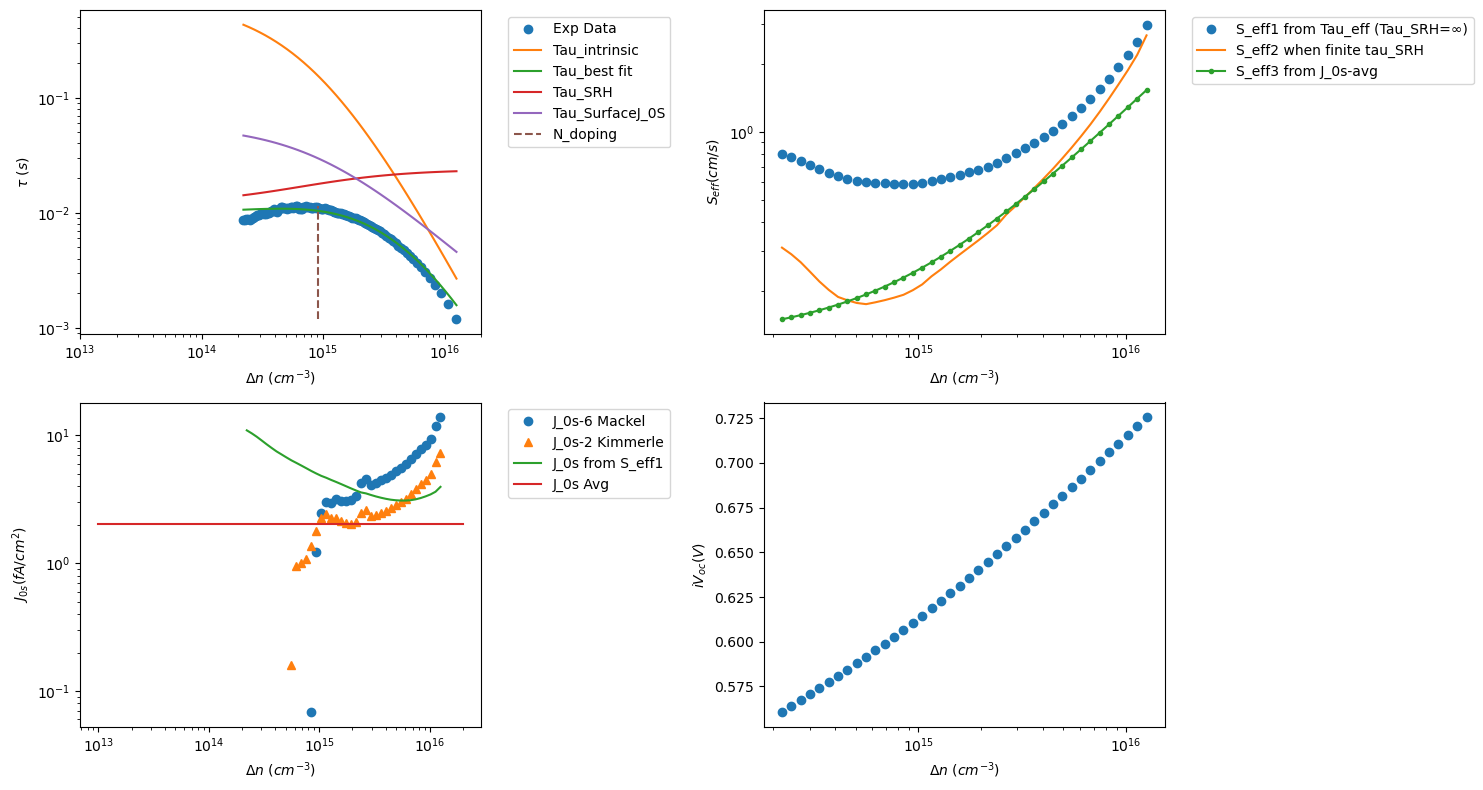

In [20]:
# make sure to include below the name of a file that exists in the selected directory.
file_name='WS-12-1030E-1122HPs4.xlsm'
# change the plot_options=0 if you do not want to plot the result of the analysis
plot_option=1;

# set any options for the fitting of SRH lifetime using the array below
srh_fit_options=np.array([0,0,0,0]) # specify values of tn [s], tp [s], Et-Ev [eV], J0 [fA/cm2] (leave as zero for fitting)

results_df=tau_func.extract_srv(df_lib[file_name],plot_option,srh_fit_options)

## if you would like to save the results into a csv file run the cell below

In [15]:
tau_func.save_file(results_df,file_name.replace('.xlsm', '.csv'))

## If you would like to analyse all of the files inside of the folder, you can use the cell below.
Execute carefully as it may take a long time to analyse very big folders.

In [21]:
delta_n_key=1e15 # you need to define at which Delta_N all resuls should be reported

#then execute the below to do the analysis
df_lib_results = {'variable':[['T_eff'],['S_eff1'],['S_eff2'],['S_eff3'],['J0avg'],['J0_Kimmerle2'],['iVoc']]}# library of all the analysed results
                  
for file_name in df_lib:
    results_df=tau_func.extract_srv(df_lib[file_name],0,srh_fit_options)
    
    # extracting all variables and defining by name
    sample_name=results_df.columns[0]
    delta_n=results_df.iloc[3,0]
    tau_eff=results_df.iloc[4,0]
    waf_thick=results_df.iloc[0,0]
    delta_n2=results_df.loc[5,sample_name]
    t_int=results_df.loc[6,sample_name]
    nieff=results_df.loc[7,sample_name]
    ndop=results_df.loc[8,sample_name]
    Joe_avg=results_df.loc[9,sample_name]
    tau_SRH=results_df.loc[10,sample_name]
    [[Seff_1],[Seff_2],[Seff_3]]=results_df.loc[11,sample_name]
    [[Joe6],[Joe2],[Joe1]]=results_df.loc[12,sample_name]
    iVoc=results_df.loc[13,sample_name]
    tau_eff2=results_df.loc[14,sample_name]
    
    df_lib_results[file_name]=[[np.interp(delta_n_key,delta_n2,tau_eff2)],
                               [np.interp(delta_n_key,delta_n2,Seff_1)],
                               [np.interp(delta_n_key,delta_n2,Seff_2)],
                               [np.interp(delta_n_key,delta_n2,Seff_3)],
                               [Joe_avg],
                               [np.interp(delta_n_key,delta_n2,Joe2)],
                               [np.interp(delta_n_key,delta_n2,iVoc)]]

In [22]:
#and finally execute this to save all your analysed results to an excel file.

df_results = pd.DataFrame.from_dict(df_lib_results)
for col in df_results:
    df_results[col] = df_results[col].astype(str).str.replace("[","").str.replace("]","")
       
df_results.to_excel("all_summary_results.xlsx")